# Collaboratory Data Assessment Fellowship

_Matt Seto - University of Washington Tacoma_ <br>
_Kristin Medlin - Collaboratory Director of Research_

This assessment fellowship aims to begin the conversation around using Collaboratory data as a mechanism for investigating institutional partnerships with community partners. 
The data is a national dataset of community engagement activities from universities around the US. Data has been de-identified. 

Our aim is to explore this data to gain insight into what makes partnerships successful. The end goal is to identify the core concepts of successful/strong partnerships so that those ideas can be promoted and encouraged at the institutional level to entice further community partnership/engagement and foster a deeper engagement between institutions and the communities that house them. 

We are attempting to identify STRONG relationships according to metrics uncovered by our adminsitrator survey:
 - Duration of projects
 - Number of activities in the DB
 - Number of students engaged with a partner
 - Faculty & Staff engaged with a partner
 - Funding for activities

 We will look at each of these metrics individually, and the result will be a list of partnerships that are the highest scorers for each metric. Upon completion of all metrics we will evaluate a way to combine each metric together into a single algorithm that can ingest a dataset and produce a top-x list of partner/institutions according to our 'strength' metrics
 
 <hr>
 
 ## Creating an initial dataset
 Get the initial dataset into the notebook, import all of the libraries we need
 

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime

activities = pd.read_csv("Data/Seto_activities.csv")

activities.shape

(2439, 32)

This dataset includes 2439 activities. 

<br>
<br>
<hr>

## Investigating Project Durations
The first metric we want to look at is the durations of projects. We will examine the data and find out the distribution of durations for all activities, we will also group the partners/universities together to create a master list of high-duration partnerships. 

The questions we want to answer in this section are: 
 - _What duration is considered high-value?_
 - _Which partner/university relationships are high-value durations?_

In [29]:
#Get the fields for activity start/end dates
projectDurations = activities.loc[:, ('portal_id', 'activity_id', 'start_time', 'end_time')]

#Fill the NAs with the CURRENT MONTH/DAY
curDate = datetime.now()
projectDurations = projectDurations.fillna(curDate)

#Set the field types
projectDurations['start_time'] = pd.to_datetime(projectDurations['start_time']).dt.date
projectDurations['end_time'] = pd.to_datetime(projectDurations['end_time']).dt.date

#Get the project durations (IN DAYS)
projectDurations["durationInDays"] = (projectDurations['end_time'] - projectDurations['start_time']).dt.days

#Set all the zeros to 30 (minimum length becomes 30 days)
projectDurations['durationInDays'] = projectDurations['durationInDays'].replace(0,30)

#Note that there were some negatives in this dataset, likely from inverted dates. Eliminate them
projectDurations = projectDurations[projectDurations['durationInDays'] >0]

#Show me the data
projectDurations['durationInDays'].describe()


count     2430.000000
mean      1202.284774
std       2035.768391
min         28.000000
25%        122.000000
50%        829.000000
75%       1409.000000
max      44324.000000
Name: durationInDays, dtype: float64

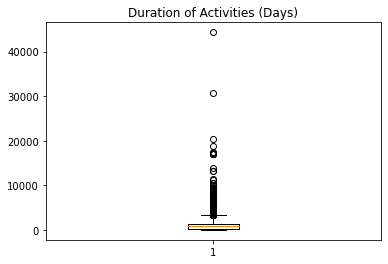

In [30]:
#Boxplot it
fig1, ax1 = plt.subplots()
ax1.set_title('Duration of Activities (Days)')
myBoxPlot = ax1.boxplot(projectDurations['durationInDays'])

So we have 2430 activities with a mean duration of 1171 days. 

If we observe the distribution, it is pretty heavily skewed because of some outliers on the high end. These might be from selection bias in the data ingestion phase. Faculty/staff might be more willing to enter data on their long term projects and not their smaller ones. 

As we continue, let's remove the fliers from the data and get a look at the distribtion

<AxesSubplot:title={'center':'Duration of Activities (Days) (Fliers Removed)'}, xlabel='durationInDays', ylabel='Count'>

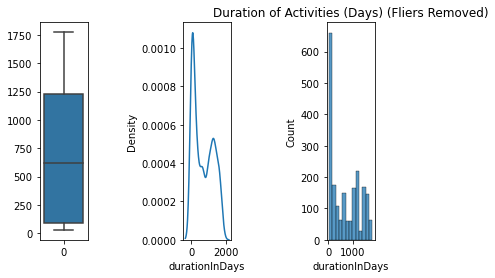

In [31]:
#Remove the fliers
#NOTE: Fliers are eliminated here. Fliers are calculated as: 
#"Call the lower quartile Q1, the upper quartile Q3, and the interquartile range IQR=Q3−Q1. Then the lower fence is at Q1−1.5(IQR) and the upper fence is at Q3+1.5(IQR)."" 
#https://nextjournal.com/schmudde/how-to-remove-outliers-in-data 
projectDurations_noFliers = projectDurations['durationInDays']
projectDurations_noFliers = projectDurations_noFliers[projectDurations_noFliers.between(projectDurations_noFliers.quantile(.15), projectDurations_noFliers.quantile(.85))]

#Plot 
fig, axs = plt.subplots(ncols=3)
fig.subplots_adjust(wspace=2)

plt.title('Duration of Activities (Days) (Fliers Removed)')

sns.boxplot(data = projectDurations_noFliers, ax = axs[0])

sns.kdeplot(data = projectDurations_noFliers, ax = axs[1])

sns.histplot(data = projectDurations_noFliers, ax = axs[2])


In [32]:
#Get the numeric results
projectDurations_noFliers.describe()

count    2062.000000
mean      675.498545
std       571.555124
min        30.000000
25%        92.000000
50%       617.000000
75%      1225.000000
max      1774.000000
Name: durationInDays, dtype: float64


Once we eliminate outliers in the data we are left with a median of 512 days (apx 17 months) of activity duration. The mean is 628 (apx 21 months). 

Additionally, We can see there are a LOT of projects that span a short period of time, we might expect thee to be one-off events, presentations, rental spaces, or short-term partnerships. While we have a lot of short term activities that might seem to indicate weak relationships, we should evaluate to see if there are partners who are represented numerous times. 

Let's SUM the duration of ALL PARTNERSHIPS BETWEEN A SCHOOL & A PARTNER to give us a better understanding of the time each have been co-engaged

In [33]:
#Get the organizations
partners = pd.read_csv("Data/Seto_organizations.csv")
partners.shape

(3856, 5)

It seems like there are 3856 partners in the database, let's join that to our activities data and start summing totals


In [34]:
#Go through the activities sheet, get the activity ID, start time, end time, 
sumProjectDurations = activities.copy()
sumProjectDurations = sumProjectDurations.loc[:, ('portal_id', 'activity_id', 'start_time', 'end_time')]

#Join the orgs to theSumProjects on the activity_id
partnersMerged = pd.merge(left=sumProjectDurations, right=partners, on='activity_id')

#Convert the start and end times to timedates
#Fill the NAs with the CURRENT MONTH/DAY
curDate = datetime.now()
partnersMerged['start_time'] = partnersMerged['start_time'].fillna(curDate)
partnersMerged['end_time'] = partnersMerged['end_time'].fillna(curDate)


#Set the field types
partnersMerged['start_time'] = pd.to_datetime(partnersMerged['start_time']).dt.date
partnersMerged['end_time'] = pd.to_datetime(partnersMerged['end_time']).dt.date


#Get the project durations (IN DAYS)
partnersMerged["durationInDays"] = (partnersMerged['end_time'] - partnersMerged['start_time']).dt.days
#Set all the zeros to 30 (minimum length becomes 30 days)
partnersMerged['durationInDays'] = partnersMerged['durationInDays'].replace(0,30)

#create the partner, school, duration array
uniPartnerDurations = {}

#define the function that will go row by row and update the uniPartnerDurations
def getUniPartnerByRow(row) :
    uni_partner = row['portal_id_x'] + "___" + row['organization_id']
    duration = row['durationInDays']
    
    if uni_partner in uniPartnerDurations :
        uniPartnerDurations[uni_partner] = uniPartnerDurations[uni_partner] + duration
    else :
        uniPartnerDurations[uni_partner] = duration
        

for k, row in partnersMerged.iterrows() :
    getUniPartnerByRow(row)
    
    
#Now I have a dictionary with University/Partner and SUM of all activities (in days)
#Start graphing it
uniPartnersDurations = pd.DataFrame.from_dict(uniPartnerDurations, orient='index', columns=['durationInDays'])

#Remove the mins for the same reason as before (some negatives in the dataset, eliminate them)
uniPartnersDurations = uniPartnersDurations[uniPartnersDurations['durationInDays'] > 0]

uniPartnersDurations.describe()

,durationInDays
count,2887.000000
mean,1713.788362
std,3303.700685
min,6.000000
25%,212.000000
50%,1013.000000
75%,1743.000000
max,55724.000000


We are going to have fliers again since we used the same activity dataset as before,

<AxesSubplot:title={'center':'Duration of Activities (Days) (Fliers Removed)'}, xlabel='durationInDays', ylabel='Count'>

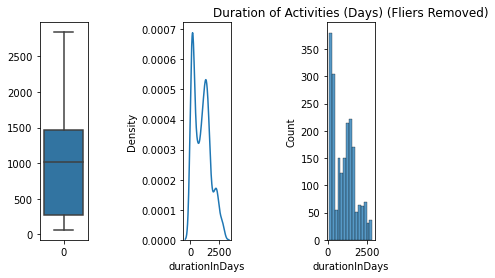

In [35]:
#Remove the fliers
#NOTE: Fliers are eliminated here. Fliers are calculated as: 
#"Call the lower quartile Q1, the upper quartile Q3, and the interquartile range IQR=Q3−Q1. Then the lower fence is at Q1−1.5(IQR) and the upper fence is at Q3+1.5(IQR)."" 
#https://nextjournal.com/schmudde/how-to-remove-outliers-in-data 

uniPartnersDurations_noFliers = uniPartnersDurations['durationInDays']
uniPartnersDurations_noFliers = uniPartnersDurations_noFliers[uniPartnersDurations_noFliers.between(uniPartnersDurations_noFliers.quantile(.15), uniPartnersDurations_noFliers.quantile(.85))]

#Plot 
fig, axs = plt.subplots(ncols=3)
fig.subplots_adjust(wspace=2)

plt.title('Duration of Activities (Days) (Fliers Removed)')

sns.boxplot(data = uniPartnersDurations_noFliers, ax = axs[0])

sns.kdeplot(data = uniPartnersDurations_noFliers, ax = axs[1])

sns.histplot(data = uniPartnersDurations_noFliers, ax = axs[2])

In [36]:
uniPartnersDurations_noFliers.describe()

count    2087.000000
mean     1001.826066
std       722.713314
min        61.000000
25%       273.000000
50%      1013.000000
75%      1470.000000
max      2839.000000
Name: durationInDays, dtype: float64

Once we combine the partner/university relationships we can see that we get a higher mean (967 days), which is coherent, as we would expect longer durations when we start adding activities together

We again see that there are a LOT of short projects, and a median of 945, in line with the mean. 

Using the data to describe "strong" relationships, we can say "any partnership with a duration 1 standard deviation above the median _or higher_ can be considered a long-term relationship, and therefore a  "Strong relationship"

In [37]:
#Mean + 1SD is our benchmark for high-value
#Make that calculation
highValueDuration = uniPartnersDurations_noFliers.mean() + uniPartnersDurations_noFliers.std()
print(highValueDuration)

1724.5393799419576


Our cutoff for high-value duations is 1673.3

_calculated as mean + 1 SD of the total durations without fliers_

In [38]:
#Get partner durations with values above the benchmark
highValueDurationPartnerships = {}

for row in uniPartnerDurations :
    if uniPartnerDurations[row] > highValueDuration :
        highValueDurationPartnerships[row] = uniPartnerDurations[row]

print(len(highValueDurationPartnerships))

738


So we have 738 partner/uni relationships that we might consider to be 'high value'

At this point we will pivot to the next metric. After we have completed all of the metric evaluations, we will ascribe weighting to each uni/partner and coalesce into a single list of 'strong partnerships'


Answers to our research questions are: 
 - _What duration is considered high-value?_
     - 1673.3
 - _Which partner/university relationships are high-value durations?_
     - We have a dictionary of 738 partner__university relationships to draw from in the next phases
     

<br>
<br>
<br>
<hr>



## Number of Activities in the Database
This metric wants to know which partners have the highest number of activities in the database. We will do a straight count to find which partners are listed the most in the database, we will use the same strategy as before, identify mean + 1sd to determine the higher-value partners that are listed

Questions to answer in this section: 
 - _How many activities is considered high-value?_
 - _Which partner/university relationships are considered to have high-value number of activities?_


In [39]:
#Get a copy of the ORGANIZATIONS dataframe
partnersCount = partners.copy()

#df[col].value_counts(dropna=False, normalize=False)
#Get the value counts for each organization
partnersCount['organization_id'].value_counts(dropna = False, normalize = False)

581501a0-f1d7-4d88-511a-4b78fda5f989    10
c4d278a8-75e1-47f7-578d-8d539072084a    10
c8d7802d-8eca-4d21-687e-f7b803731ea7    10
c794dad7-794c-4cf1-6893-06dfa761b6fe     9
34659427-5feb-470f-683f-e805c595fe8f     9
                                        ..
01599ad0-ac4e-4485-7cc8-69cc4e13fded     1
68ed1895-b570-4b80-54cb-ed8a05d0b84e     1
0e74a924-148b-4318-4777-c3fcb435f158     1
fe5c71b9-6c44-4d4a-73f3-04010add5518     1
5ed55cbf-21b9-46ba-74fb-22a839536151     1
Name: organization_id, Length: 2897, dtype: int64

When we count how often a partner appears in the table we see that the highest number of times a partner appears is 10, let's graph these to see the distribution of how many times a partner appears



<AxesSubplot:title={'center':'Count of Activities for Each Partner Org'}, xlabel='organization_id', ylabel='Count'>

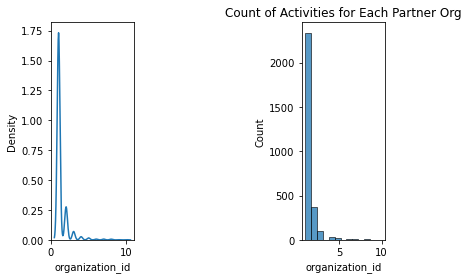

In [40]:
#Plot 
fig, axs = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=2)
plt.title('Count of Activities for Each Partner Org')

sns.kdeplot(data = partnersCount['organization_id'].value_counts(dropna = False, normalize = False), ax = axs[0])

sns.histplot(data = partnersCount['organization_id'].value_counts(dropna = False, normalize = False), ax = axs[1])

In [41]:
#How many partners are there in total?
partnersCount['organization_id'].count()

3856

In [42]:
#Find out how many partners are greater than 1 activity in the DB
partnersCount.groupby("organization_id").filter(lambda x: len(x) > 1).count()

activity_id                1518
portal_id                  1518
organization_id            1518
type                       1518
community_partner_roles    1475
dtype: int64

The VAST majority of partners are engaged in only one activity. 


Rather than set a cutoff value for high-frequency partnerships, we will assume that any partnership with more than 1 activity in the database is considered 'high-frequency'. 

Of the 3856 partners listed in the Db, only 1518 of them have more than one activity. 


<br>
<br>
<br>
<hr>

## Number of Students Involved in Activities

To calculate the number of students involved with a partner, we will go back to grouping University/partner relationships, and then sum the total number of students involed with each row. This is very similar to the first section (amount of time engaged). 

Research Questions in this section: 
 - _How many students per partner is considered high-value?_
 - _Which university/partner combos are considered to be high-value for student involvement?_

In [43]:
#Make a copy of the data
studentCounts = activities.copy()
studentPartners = partners.copy()

#Get the student fields
studentFields = ['activity_id','student_members']
studentCounts = studentCounts[studentFields]

#Merge the partners with the activities
studentsMerged = pd.merge(studentCounts, studentPartners, how='left', on=['activity_id'])

#Make a pivot table of the merged frame
studentsPivot = pd.pivot_table(studentsMerged, index=['portal_id', 'organization_id'], values=['student_members'], aggfunc='sum')

#Show the studentMembers details
studentsPivot['student_members'].describe()

count    2897.000000
mean       22.650673
std       107.279445
min         0.000000
25%         0.000000
50%         0.000000
75%         6.000000
max      2500.000000
Name: student_members, dtype: float64

When we set up the data to sum the number of students between institutions and partners, we see that there is a very strange distribution. The mean is 22, but the max is 2500. The 75th percentile is only 6. This data is highly skewed left. 

We can observe that on a chart:

<AxesSubplot:title={'center':'Number of students a university is sending to a partner (cumulative of all activities)'}, xlabel='student_members', ylabel='Density'>

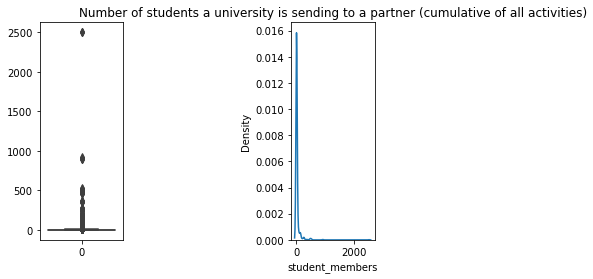

In [44]:
#Plot 
fig, axs = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=2)

plt.title('Number of students a university is sending to a partner (cumulative of all activities)')

sns.boxplot(data = studentsPivot['student_members'], ax = axs[0])

sns.kdeplot(data = studentsPivot['student_members'], ax = axs[1])


It is indeed highly skewed to zero. 

For our purposes we will eliminate the student activity as part of our investigation. This data is VALID, and has uses beyond the scope of this assessment. However we are seeking to find cut-off values for strong partnerships, and with such a highly-skewed dataset our data is too left-leaning to use in this project. 

As next steps we need to investigate the reasons for this skew. A whole realm of reasearch exists for this section alone. 
<br>
<br>
<br>
<hr>

## Number of Faculty/Staff Associated with a Partner
This section is similar to the previous section re: students. We want to evaluate the number of faculty/staff that are associated with activities with a single partner. The mechanism remains the same and the research questions become: 

Research Questions in this section: 
 - _How many faculty/staff per partner is considered high-value?_
 - _Which university/partner combos are considered to be high-value for faculty/staff involvement?_

In [45]:
#Make a copy of the data
facultyCounts = activities.copy()
facultyPartners = partners.copy()

#Get the student fields
facultyFields = ['activity_id', 'faculty_members']
facultyCounts = facultyCounts[facultyFields]

#Merge the partners with the activities
facultyMerged = pd.merge(facultyCounts, facultyPartners, how='left', on=['activity_id'])

#Make a pivot table of the merged frame
facultyPivot = pd.pivot_table(facultyMerged, index=['portal_id', 'organization_id'], values=['faculty_members'], aggfunc='sum')

#Show the studentMembers details
facultyPivot['faculty_members'].describe()

count    2897.000000
mean        7.339317
std        42.682406
min        -1.000000
25%         0.000000
50%         0.000000
75%         3.000000
max       608.000000
Name: faculty_members, dtype: float64

We can see that the mean faculty/staff count is 7, with a highly left skewed dataset again. When we chart it we should see similar results to the students section

Interestingly, we see a -1, and a max of 608. 

<AxesSubplot:title={'center':'Number of faculty/staff a university is sending to a partner (cumulative of all activities)'}, xlabel='faculty_members', ylabel='Density'>

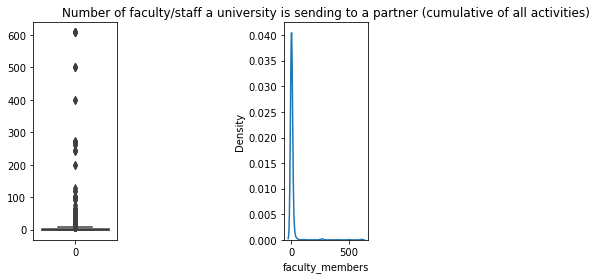

In [46]:
#Plot 
fig, axs = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=2)

plt.title('Number of faculty/staff a university is sending to a partner (cumulative of all activities)')

sns.boxplot(data = facultyPivot['faculty_members'], ax = axs[0])

sns.kdeplot(data = facultyPivot['faculty_members'], ax = axs[1])

Similarly to the count of students, we see a highly left-skewed dataset here. For our purposes we won't be including it in our proxy values for strong partnerships. 

Again, there is a lot of data to unpack in this section. For example we need to investigate why such a narrow distribution. Similar to the student data this section alone offers a lot of research avenues. For the previous sections (students and faculty/staff) we can also begin to investigate why they are so left skewed. How many rows actually had values? Why aren't people adding that data? 

<br>
<hr>

## Funding

Note that funding was not immediately noted by Collaboratory administrators as a key component of strong partnerships, but with the dataset that we have it is worth exploring the data. 

Examining the funding for partnerships, which university/partner combos have the most funding? 

Research Questions in this section: 
 - _What is the average dollar value per funded projects?_
 - _What is the cutoff for considering high-value partnerships based on funding dollar values?_
 

In [47]:
#Get a copy of the organizations DF
partnerships = pd.read_csv("Data/Seto_organizations.csv")
partnerships = partnerships[["activity_id", "portal_id", "organization_id"]]

#Get a copy of the funders DF
funders = pd.read_csv("Data/Seto-activity_funders.csv")
funders = funders[["activity_id", "amount"]]

#Merge funders to partnerships
fundingMerged = pd.merge(partnerships, funders, how='left', on=['activity_id'])

#Drop any rows where there is no amount (where there isn't a funder)
fundingMerged = fundingMerged[fundingMerged['amount'].notna()]

#How many funded activities are there?
fundingMerged.shape[0]

821

There are 821 incidents of funding, but how does this align with a partnership? We can assume that partnerships may have more than one funding source so we need to merge together partnerships and then calculate the TOTAL funding dollars per university/partner relationship

In [48]:
#Group the funded activities into partnerships (portal_id + organization_id)
fundingMerged_pivot = pd.pivot_table(fundingMerged, index=['portal_id', 'organization_id'], values=['amount'], aggfunc='sum')
#show me
fundingMerged_pivot['amount'].describe().apply(lambda x: format(x, 'f'))

count         460.000000
mean       599356.667391
std       1688341.051692
min             0.000000
25%           700.000000
50%         10000.000000
75%        149250.000000
max      12445645.000000
Name: amount, dtype: object

When we sum together all the funding per partnership we can start to examine the dollar values for each. 

We can see that there are 460 partnerships with at least one funder. The average is $599,356 dollars of funding. 

There is one partnership with over $12,000,000 dollars in funding!

In [49]:
#Let's see what the sum of all funding is, just for curiosity
fundingMerged_pivot['amount'].sum()

275704067.0


So we graph the distribution of funding to see what the curve looks like:

<AxesSubplot:title={'center':'Distribution of funding amounts'}, xlabel='amount', ylabel='Density'>

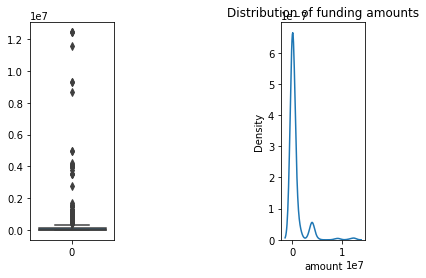

In [50]:
#Plot
fig, axs = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=2)

plt.title('Distribution of funding amounts')

sns.boxplot(data = fundingMerged_pivot['amount'], ax = axs[0])

sns.kdeplot(data = fundingMerged_pivot['amount'], ax = axs[1])

## Funding Results
We see that there are 460 partnerships that are funded by at least one funder. 

The MEAN funding value is 599,356
<br>
The MAX funding value is 12,445,645 

Therefore let's assume that high value is ANY activity that is funded. 
NEXT STEP can be to tier the rankings by value if we want


<br>
<br>
For curiosity, I also wanted to see how much funding in total was in the Collaboratory data. There is over $275 million dollars in funding listed in these activities!


<br>
<br>
<hr>

# Putting it all Together!

We know the cutoff values now as:
 - 1673 days or longer of engagement
 - appears more than 1 time in the activities list
 - Has a funder
 
 So let's process it!

In [51]:
#First get the durations of all partnerships

#Get the fields for activity start/end dates
projectDurations = activities.loc[:, ('portal_id', 'activity_id', 'start_time', 'end_time')]

#Fill the NAs with the CURRENT MONTH/DAY
curDate = datetime.now()
projectDurations = projectDurations.fillna(curDate)

#Set the field types
projectDurations['start_time'] = pd.to_datetime(projectDurations['start_time']).dt.date
projectDurations['end_time'] = pd.to_datetime(projectDurations['end_time']).dt.date

#Get the project durations (IN DAYS)
projectDurations["durationInDays"] = (projectDurations['end_time'] - projectDurations['start_time']).dt.days

#Set all the zeros to 30 (minimum length becomes 30 days)
projectDurations['durationInDays'] = projectDurations['durationInDays'].replace(0,30)

#Note that there were some negatives in this dataset, likely from inverted dates. Eliminate them
projectDurations = projectDurations[projectDurations['durationInDays'] >0]

#get the partner organizations
partners = pd.read_csv("Data/Seto_organizations.csv")
partners = partners[['activity_id', 'organization_id']]

#Merge the activities with the partners
partnerDurations = pd.merge(partners, projectDurations, how='left', on=['activity_id'])

#drop columns we don't need
partnerDurations = partnerDurations[['activity_id', 'organization_id', 'portal_id', 'durationInDays']]

#get only the relations where the duration is above the threshold
partnerDuration = partnerDurations[partnerDurations['durationInDays'] > 1672]

#How many are there?
partnerDuration.shape


(813, 4)

In [52]:
#From this list, get ONLY the activities that are funded
fundedActivities = pd.read_csv('Data/Seto-activity_funders.csv')
fundedActivities = fundedActivities[['activity_id', 'amount']]

#Merge with the partner durations, ONLY KEEP ONES THAT ARE FUNDED
fundedPartners = pd.merge(fundedActivities, partnerDuration, how='inner', on=['activity_id'])

#How many are there?
fundedPartners.shape

(207, 5)

In [53]:
#From that list, get ONLY institution/partner combos that appear more than once (ie: partners are in multiple activities)
fundedPartners = fundedPartners[fundedPartners.duplicated(subset=['organization_id', 'portal_id'], keep=False)]

#How many are there?
fundedPartners.shape

(104, 5)

In [54]:
highPriority = fundedPartners[['organization_id', 'portal_id']]
highPriority.head(104)

,organization_id,portal_id
1,0c4bf258-317b-41ba-5b02-24cbdc9f788e,de3eb711-9ae8-43e3-6ef0-8fc2da9c62c1
3,8d30082e-ee12-4657-7cc2-d9fe48190caa,de3eb711-9ae8-43e3-6ef0-8fc2da9c62c1
6,0c4bf258-317b-41ba-5b02-24cbdc9f788e,de3eb711-9ae8-43e3-6ef0-8fc2da9c62c1
7,e9216580-7848-44c3-53ae-33039212f716,de3eb711-9ae8-43e3-6ef0-8fc2da9c62c1
8,0c4bf258-317b-41ba-5b02-24cbdc9f788e,de3eb711-9ae8-43e3-6ef0-8fc2da9c62c1
...,...,...
191,0c20563c-33e0-4b2e-52b4-4eb91a360525,de3eb711-9ae8-43e3-6ef0-8fc2da9c62c1
192,5a1d1063-6fa0-45ff-5812-0c1b2d85750b,de3eb711-9ae8-43e3-6ef0-8fc2da9c62c1
193,c7a9e7dd-2c12-45c8-6f42-f8a45c9786d1,de3eb711-9ae8-43e3-6ef0-8fc2da9c62c1
197,89e5f525-d443-41e0-4c07-888adb2599ff,256fead7-f6aa-4f58-6523-6e456da8e342


### Success!
<br>
What we have now is a table of Organizations & Partners that meet all three of the criteria that we laid out above. 

There are 104 partnerships that meet our 'strong partnership' threshold as identified in our data exploration. 

<br>
<br>
<hr>

# Next Steps
Now that we've identified the partnerships that we _think_ are strong, the next logical steps for this reasearch are to validate those responses. 

Additionally, we know there are certain thresholds to be considered 'high value' according to what we've done here. However there are multiple ways to slice this data. Going back to each step and conducting deeper analysis on each proxy category may yeild different results
<br>
<hr>
<br>

# Conclusions

Collaboratory data is very robust and contains data on community engagement on a scale that doesn't exist elsewhere. This exploratory research fellowship offers a first chance at exploring the data to begin to understand data-driven perspectives on community engaged activities. 

Each proxy category offers another opportunity for further analysis, either in evaluating or assessing partnerships, or as a means of examining the data intake process to streamline data capture. 

This exploratory analysis has proven exceptionally fruitful and offers a first-glimpse into the possibilities of exploring this data. 

<br>
<br>
<hr>
<br>

This analysis was performed by:
Matt Seto - University of Washington Tacoma

In conjunction with Kristin Medlin - Collaboratory Director of Research

As part of the Collaboratory Research Assessment Fellowship